# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit

## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,stand,59,0.3608677355979031,2.7655574767746303,0.20870629032593843,0.6581472034160547,...,-1.5096047609935206,0.5374402120462101,0.24725567691914474,-1.1548519667455222,-0.9176895137907444,0.19853266525825441,-0.6351422949522179,-0.9240468871850966,-0.6043028159859238,-0.40440680981149635
1,101,0,2,1,stand,44,0.11857848631771781,2.2982802008603884,0.22148909073910306,0.8313514219454735,...,-1.280617105642371,0.7268055218978855,-1.7517830977424425,-0.7701703570143632,0.4187723636318532,1.0481449056142007,-0.9030033089456406,-0.19860783889835965,0.8934212147732565,-0.276497605679932
2,101,0,3,1,stand,53,0.24619052972163322,3.445303563459787,0.20016295285928792,0.9602665690153961,...,-1.4552465068519256,0.1405061114156383,0.7198891878500557,-0.5806536048592652,-0.76127983523148,-0.3931234568509234,0.412760624339358,-1.007601590228747,-0.4138693928861996,-0.5305323879118911
3,101,0,4,1,stand,57,0.28321350295077613,3.626021938955907,0.3449046585971368,0.5731684465708434,...,-1.51459552588099,1.0602340465863236,0.4958653590427531,-0.13640312363512264,-0.5844906010216535,-0.6109341257432597,-1.3306916169093075,-1.4875437672995169,-1.2588076707533085,-0.057357413926721
4,101,0,5,1,stand,60,0.39363598833851376,3.767306517718122,0.2176579492233252,0.6589984240898876,...,-1.3601464899179059,-1.527706279445947,0.39390720825161907,-0.42688443195923,-0.5349520236928611,-1.1701446029912246,-0.8445014311637222,-1.4273439546363045,-0.33874666284848587,-0.32227339359147944


In [3]:
test_result = pd.DataFrame({'classifier': ['K-Neighbors',
                                            'Decision tree',
                                            'Naive Bayes',
                                            'Suport Vector Machine',
                                            'Random Forest']})


## 1. Preprocesado

### 1.1 Codificar variables

In [4]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [5]:
# Dividimos los datos en varibales independientes y en target
X = df.drop(['GestureLabel'], axis = 1)
y = pd.DataFrame(df['GestureLabel'])

# Dividimos en train y test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)    

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [6]:
#-------Funcion para evaluar los modelos-----------
def test_models(modelos, tX, ty, df, column_name):
   new_evaluation = []
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      score = f1_score(test_y, prediction, average='weighted', zero_division=0) 
      new_evaluation.append(score)
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
   df.loc[:, column_name] = new_evaluation



In [7]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty, ax=None):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """

    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_title('Confusion Matrix ' + modelo.__class__.__name__)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')


In [8]:
knn = KNeighborsClassifier() # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier()  # Random Forest

models = [knn, dtree, nb, svm, rf]

for modelo in models:
    modelo.fit(train_X, train_y) # entrenamos el modelo



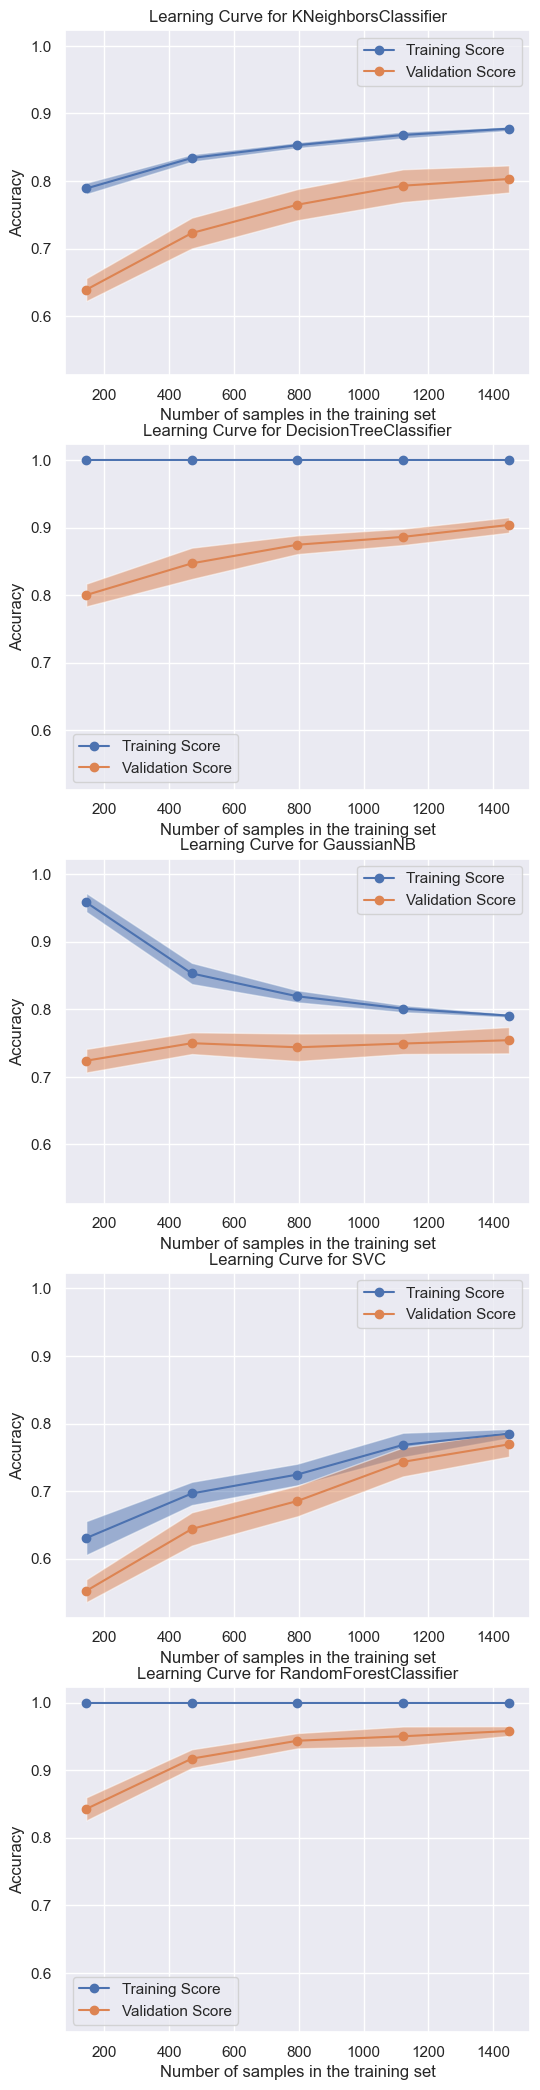

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6, 26), sharey=True)

common_params = {
    "X": train_X,
    "y": train_y,
    # "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
for ax_idx, estimator in enumerate(models):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Validation Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [10]:
# entrenamiento + evaluación
test_models(models, test_X, test_y, test_result, 'modelos')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        77
           1       0.92      0.94      0.93        84
           2       0.76      0.80      0.78       113
           3       0.78      0.82      0.80        96
           4       0.78      0.69      0.73        83
           5       0.76      0.69      0.72        77
           6       0.94      0.87      0.91        78
           7       0.84      0.90      0.87        82
           8       0.85      0.84      0.84        87

    accuracy                           0.83       777
   macro avg       0.83      0.83      0.83       777
weighted avg       0.83      0.83      0.83       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        77
           1       0.91      0.95      0.93        84
           2       0.89      0.93      0.91       113
           3    

## 3. Hipermetrización

In [11]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter for LogisticRegression
    'penalty': ['l1', 'l2'],  # Penalty term for LogisticRegression
    'max_iter': [4000, 4500]  # Maximum number of iterations for LogisticRegression
}

In [12]:
def aplicar_hiperparametrizacion(X, y):
    gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
    gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=5, scoring='accuracy')
    gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy')
    gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
    gs_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

    
    common_params = {
        "X": X,
        "y": y,
        "cv": 5,
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }


    modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

    best_models = []
    for modelo in modelos:
        modelo.fit(X, y)
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        # print(modelo.cv_results_) 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)
        best_models.append(modelo.best_estimator_)

        LearningCurveDisplay.from_estimator(modelo, **common_params)
        plt.legend(["Training Score", "Validation Score"])
        plt.title(f"Learning Curve for {modelo.estimator.__class__.__name__}")
        plt.show()

    return best_models
    


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 1}
Best score:  0.8371839946425581


<Figure size 600x400 with 0 Axes>

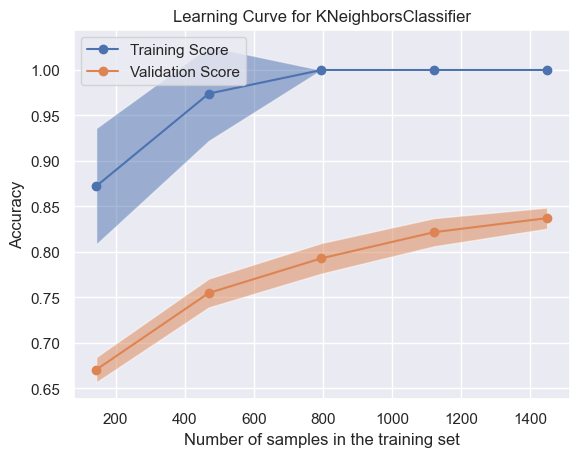


Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40}
Best score:  0.9149932270976973


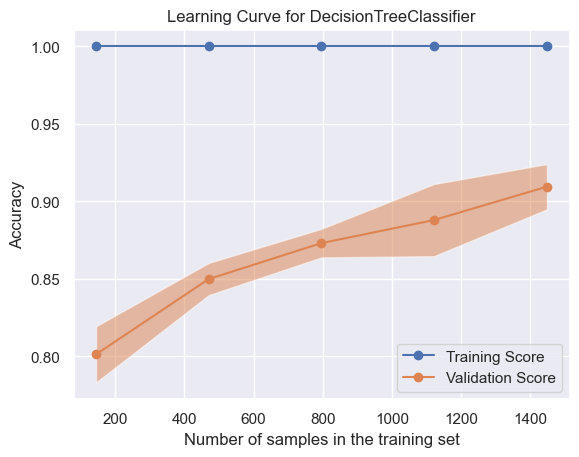


Modelo: GaussianNB
Best parameters:  {'var_smoothing': 8.111308307896873e-06}
Best score:  0.7632269454971615


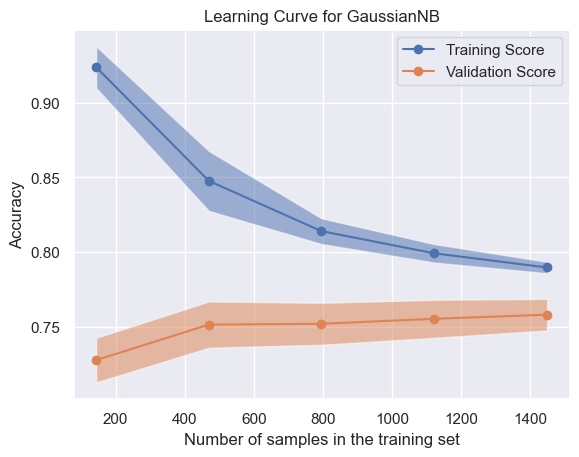


Modelo: SVC
Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.9315525927278815


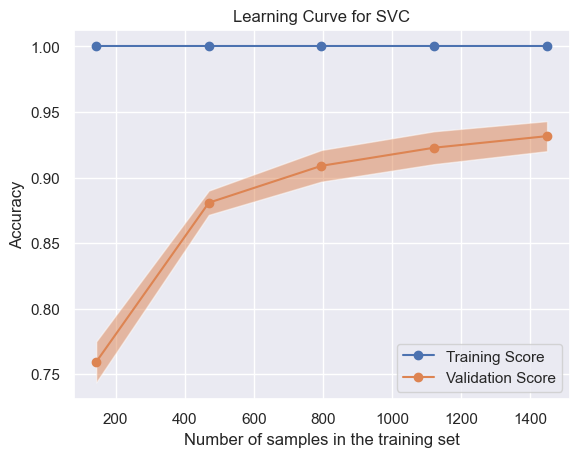


Modelo: RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 50}
Best score:  0.9597035142991949


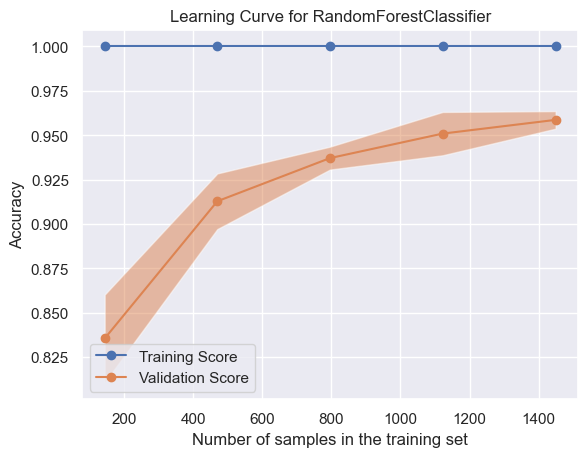

In [13]:
plt.figure(figsize=(6,4))

best_models = aplicar_hiperparametrizacion(train_X, train_y)

In [14]:
test_models(best_models, test_X, test_y, test_result, 'hiperparametros')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        77
           1       0.93      0.94      0.93        84
           2       0.76      0.81      0.79       113
           3       0.88      0.82      0.85        96
           4       0.82      0.76      0.79        83
           5       0.78      0.86      0.81        77
           6       0.95      0.88      0.91        78
           7       0.91      0.91      0.91        82
           8       0.90      0.87      0.89        87

    accuracy                           0.86       777
   macro avg       0.87      0.87      0.87       777
weighted avg       0.86      0.86      0.86       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        77
           1       0.88      0.94      0.91        84
           2       0.92      0.96      0.94       113
           3    

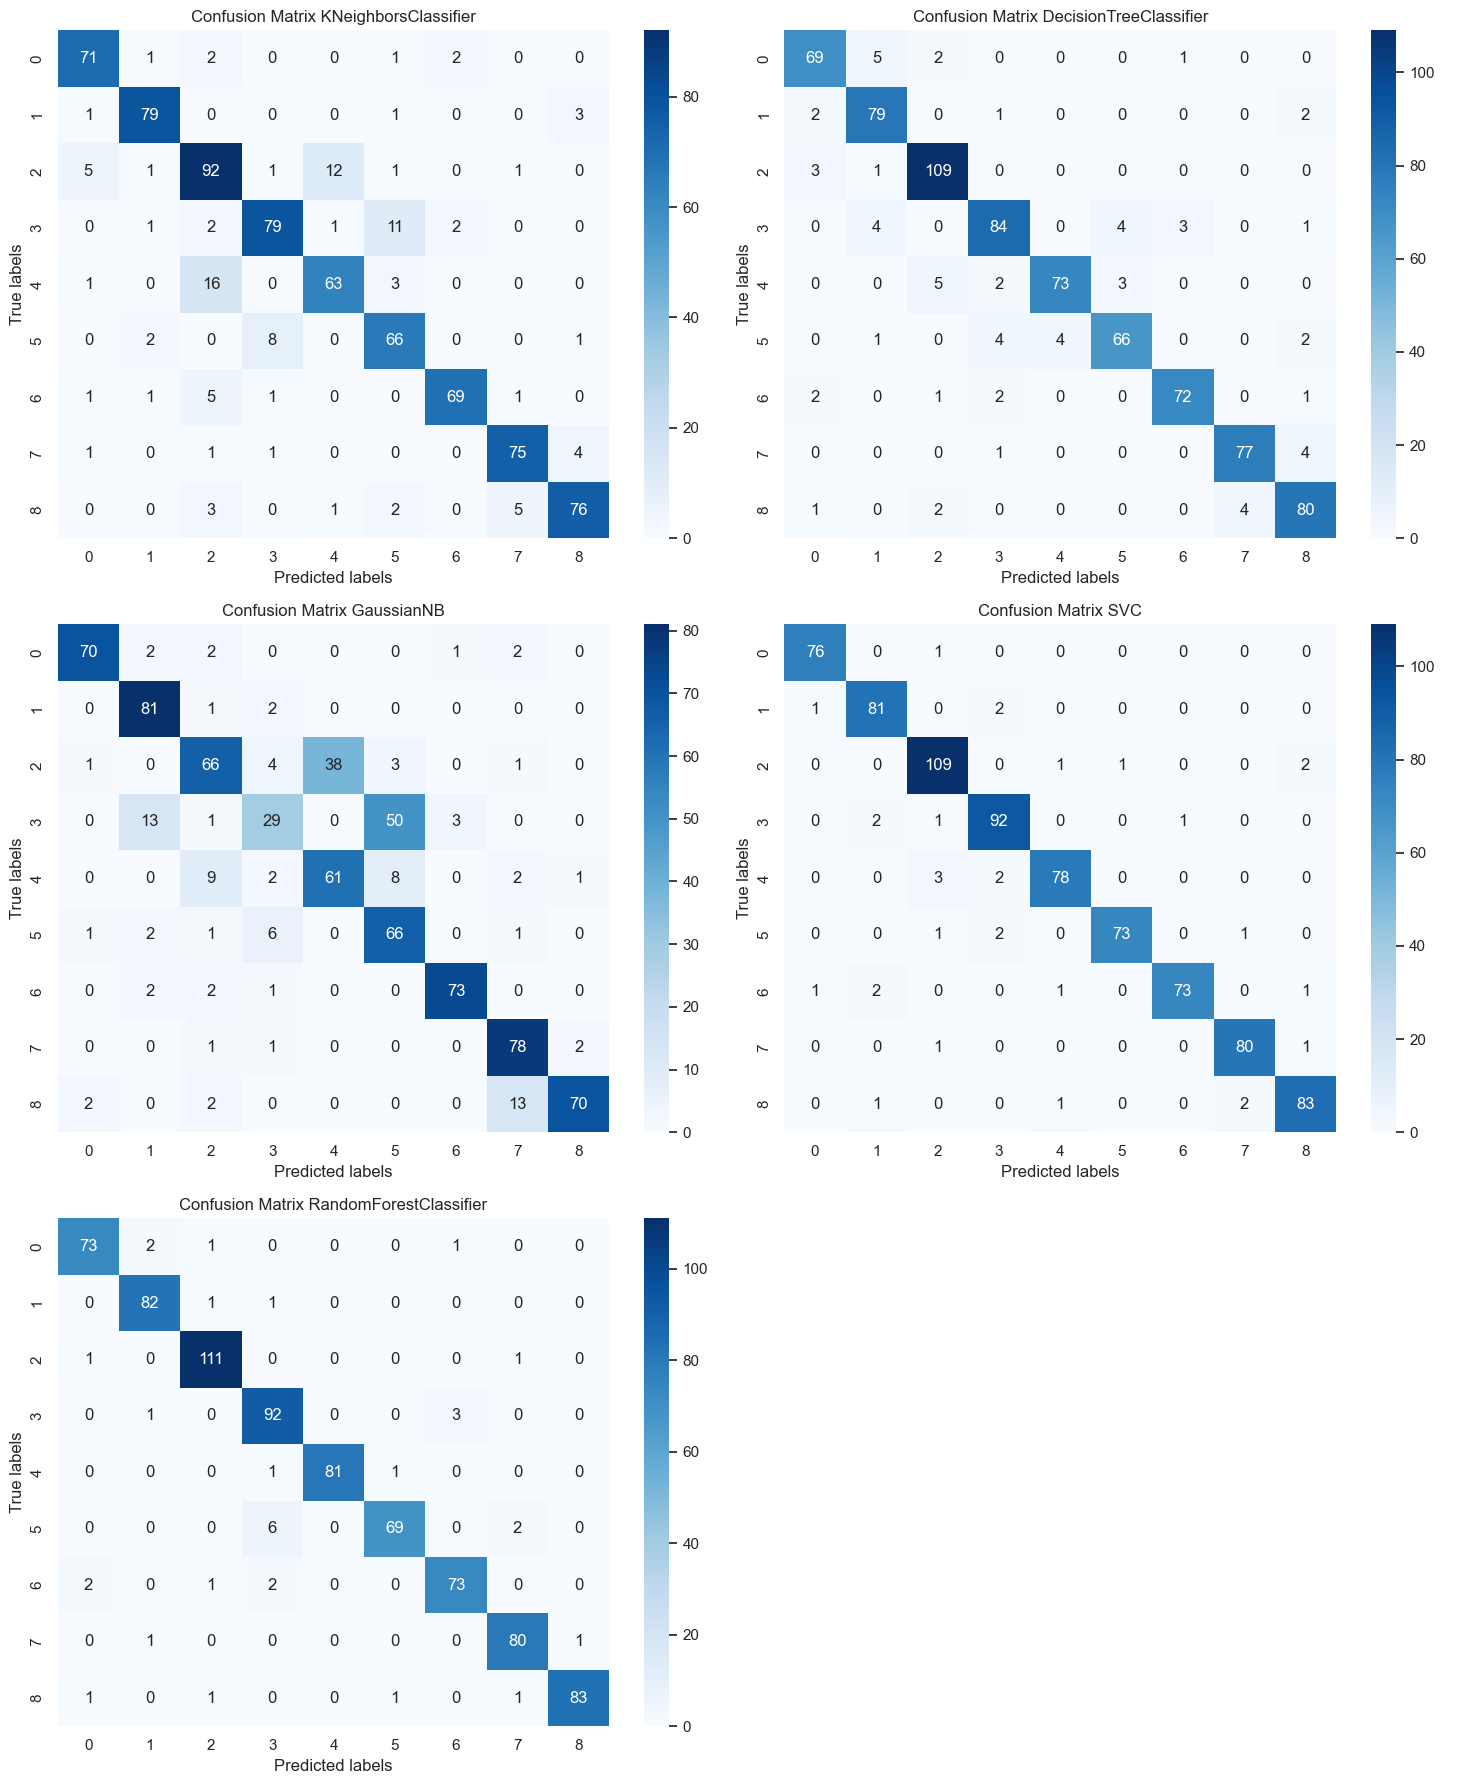

In [15]:
#-----------matriz de confusión-----
num_models = len(best_models)
num_cols = 2  # Number of matrices per row
num_rows = (num_models + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))


for i, modelo in enumerate(best_models):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    plot_confusion_matrix(modelo, test_X, test_y, ax=ax)
    # Hide unused subplots
for i in range(num_models, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Feature Selection

### 4.1 SelectKBest

In [16]:
# Definimos feature Selection K=50 (selecciona entonces las 50 variables que considere mas importantes)
feature_selection=SelectKBest(k=50)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

Index(['HipAngleLeft_standardDeviation', 'RightArmAngle_standardDeviation',
       'ElbowAngleRight_standardDeviation', 'LeftArmAngle_standardDeviation',
       'ShoulderAngleRight_standardDeviation',
       'ElbowAngleLeft_standardDeviation',
       'ShoulderAngleLeft_standardDeviation',
       'HipAngleRight_standardDeviation',
       'ArmsTogetherAngle_standardDeviation', 'ElbowAngleRight_Maximum',
       'ShoulderAngleRight_Maximum', 'ElbowAngleLeft_Maximum',
       'ShoulderAngleLeft_Maximum', 'RightArmAngle_Minimum',
       'LeftArmAngle_Minimum', 'ShoulderAngleRight_Minimum',
       'ShoulderAngleLeft_Minimum', 'ArmsTogetherAngle_Minimum',
       'RightArmAngle_Mean', 'ElbowAngleRight_Mean', 'LeftArmAngle_Mean',
       'ShoulderAngleRight_Mean', 'ElbowAngleLeft_Mean',
       'ShoulderAngleLeft_Mean', 'ArmsTogetherAngle_Mean',
       'RightArmAngle_Range', 'KneeAngleLeft_Range', 'ElbowAngleRight_Range',
       'LeftArmAngle_Range', 'ShoulderAngleRight_Range',
       'ElbowAngleLe

### 4.2 Entrenar con las variables sleccionadas

In [17]:
# creación de los modelos
knn_fs = KNeighborsClassifier() # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier()  # Random Forest

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs]


In [18]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])

for modelo in models_fs:
        print(f"\nModelo: {modelo.__class__.__name__}")
        modelo.fit(X_fs, train_y)
        scores = cross_val_score(modelo, X_fs, train_y, scoring='accuracy', cv=5)
        print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



Modelo: KNeighborsClassifier
0.83 accuracy with a standard deviation of 0.02

Modelo: DecisionTreeClassifier
0.91 accuracy with a standard deviation of 0.01

Modelo: GaussianNB
0.77 accuracy with a standard deviation of 0.02

Modelo: SVC
0.69 accuracy with a standard deviation of 0.02

Modelo: RandomForestClassifier
0.95 accuracy with a standard deviation of 0.01


In [19]:
X_fs_test = pd.DataFrame(feature_selection.transform(test_X),
                 columns=test_X.columns[selected])
test_models(models_fs, X_fs_test, test_y, test_result, 'FS')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        77
           1       0.86      0.98      0.92        84
           2       0.82      0.74      0.78       113
           3       0.78      0.73      0.75        96
           4       0.72      0.83      0.77        83
           5       0.71      0.71      0.71        77
           6       0.99      0.87      0.93        78
           7       0.96      0.91      0.94        82
           8       0.88      0.87      0.88        87

    accuracy                           0.84       777
   macro avg       0.84      0.84      0.84       777
weighted avg       0.84      0.84      0.84       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        77
           1       0.92      0.96      0.94        84
           2       0.89      0.91      0.90       113
           3    

In [20]:
for modelo in best_models:
    modelo.fit(X_fs, train_y)
test_models(best_models, X_fs_test, test_y, test_result, 'H+Fs')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        77
           1       0.91      0.96      0.94        84
           2       0.83      0.84      0.84       113
           3       0.78      0.77      0.77        96
           4       0.78      0.83      0.81        83
           5       0.73      0.71      0.72        77
           6       0.97      0.88      0.93        78
           7       0.94      0.94      0.94        82
           8       0.92      0.90      0.91        87

    accuracy                           0.86       777
   macro avg       0.86      0.86      0.86       777
weighted avg       0.86      0.86      0.86       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        77
           1       0.93      0.94      0.93        84
           2       0.94      0.94      0.94       113
           3    

### 4.3 Recursive feature elimination

In [21]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest

models_with_coef = [dtree_rfe, rf_rfe]


Modelo: DecisionTreeClassifier
Optimal number of features: 119
['RepetitionNumber' 'CorrectLabel' 'Position' 'Duration'
 'HipAngleLeft_standardDeviation' 'RightArmAngle_standardDeviation'
 'KneeAngleLeft_standardDeviation' 'AnkleAngleLeft_standardDeviation'
 'KneeAngleRight_standardDeviation' 'ElbowAngleRight_standardDeviation'
 'LeftArmAngle_standardDeviation' 'ShoulderAngleRight_standardDeviation'
 'WristAngleLeft_standardDeviation' 'ElbowAngleLeft_standardDeviation'
 'WristAngleRight_standardDeviation' 'ShoulderAngleLeft_standardDeviation'
 'HipAngleRight_standardDeviation' 'ArmsTogetherAngle_standardDeviation'
 'AnkleAngleRight_standardDeviation' 'HipAngleLeft_Maximum'
 'RightArmAngle_Maximum' 'KneeAngleLeft_Maximum' 'AnkleAngleLeft_Maximum'
 'KneeAngleRight_Maximum' 'ElbowAngleRight_Maximum' 'LeftArmAngle_Maximum'
 'ShoulderAngleRight_Maximum' 'WristAngleLeft_Maximum'
 'ElbowAngleLeft_Maximum' 'WristAngleRight_Maximum'
 'ShoulderAngleLeft_Maximum' 'HipAngleRight_Maximum'
 'ArmsTo

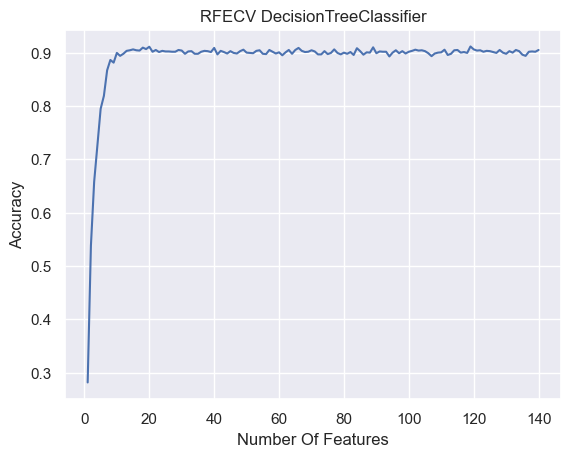


Modelo: RandomForestClassifier
Optimal number of features: 50
['HipAngleLeft_standardDeviation' 'RightArmAngle_standardDeviation'
 'KneeAngleLeft_standardDeviation' 'ElbowAngleRight_standardDeviation'
 'ShoulderAngleRight_standardDeviation' 'ElbowAngleLeft_standardDeviation'
 'HipAngleLeft_Maximum' 'RightArmAngle_Maximum' 'ElbowAngleRight_Maximum'
 'ShoulderAngleRight_Maximum' 'ElbowAngleLeft_Maximum'
 'ShoulderAngleLeft_Maximum' 'HipAngleRight_Maximum'
 'RightArmAngle_Minimum' 'LeftArmAngle_Minimum'
 'ShoulderAngleRight_Minimum' 'ShoulderAngleLeft_Minimum'
 'ArmsTogetherAngle_Minimum' 'RightArmAngle_Mean' 'ElbowAngleRight_Mean'
 'LeftArmAngle_Mean' 'ShoulderAngleRight_Mean' 'ElbowAngleLeft_Mean'
 'ShoulderAngleLeft_Mean' 'ArmsTogetherAngle_Mean' 'HipAngleLeft_Range'
 'KneeAngleLeft_Range' 'AnkleAngleLeft_Range' 'KneeAngleRight_Range'
 'ElbowAngleRight_Range' 'LeftArmAngle_Range' 'ShoulderAngleRight_Range'
 'ElbowAngleLeft_Range' 'AnkleAngleRight_Range' 'HipAngleLeft_Variance'
 'Right

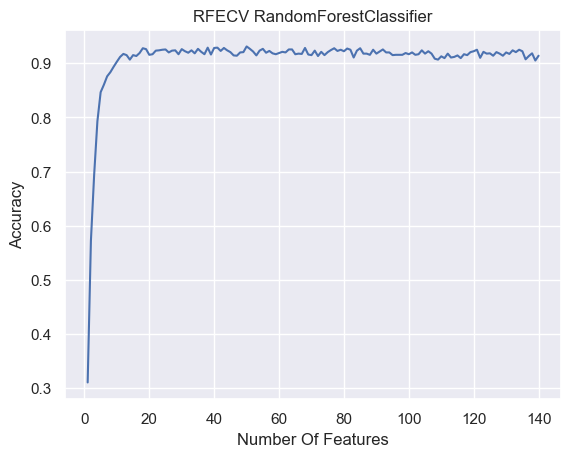

In [22]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        print(rfecv.score)
        cv_results = pd.DataFrame(rfecv.cv_results_)
        plt.title(f"RFECV {rfecv.estimator.__class__.__name__}")
        plt.xlabel("Number Of Features")
        plt.ylabel("Accuracy")
        plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'])
        plt.show()

seleccion_variables(models_with_coef, train_X, train_y)

# Evaluación modelos

In [23]:
test_result

,classifier,modelos,hiperparametros,FS,H+Fs
0,K-Neighbors,0.827816,0.862677,0.838915,0.861035
1,Decision tree,0.909750,0.912343,0.900637,0.912434
2,Naive Bayes,0.734375,0.755071,0.769231,0.742744
3,Suport Vector Machine,0.768060,0.958839,0.648053,0.943378
4,Random Forest,0.961474,0.957557,0.951201,0.948546


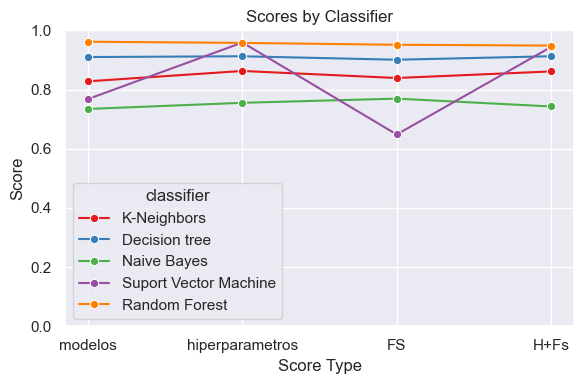

In [24]:
# Melt the dataframe to transform it into long format
df_melted = pd.melt(test_result, id_vars=['classifier'], value_vars=['modelos', 'hiperparametros', 'FS', 'H+Fs'],
                    var_name='score_type', value_name='score')

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.lineplot(x='score_type', y='score', hue='classifier', data=df_melted, marker='o', palette='Set1')

# Set labels and title
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.title('Scores by Classifier')
plt.ylim(0,1)

# Display the plot
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()